In [1]:
from keras.models import Sequential
from keras.layers import ConvLSTM2D, Conv3D, Dense, Flatten, GlobalAveragePooling2D, Conv2D, BatchNormalization, Reshape
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.backend import sum
from keras.layers import ConvLSTM2D, BatchNormalization, Conv3D, AveragePooling3D, Reshape,Dense,AveragePooling2D,GlobalAveragePooling2D, GlobalAveragePooling3D, Conv2D, MaxPooling2D, Flatten, TimeDistributed, Lambda, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import rmsprop, adam
from keras.models import load_model

Using TensorFlow backend.


In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

C:\Users\bigBro\AppData\Roaming\Python\Python37\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

In [4]:
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import gc
import tensorflow

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))

In [4]:
h5f = h5py.File('D:/total_data_ro.h5','r')

In [5]:
data = h5f['total_2018'][:]
data_val = h5f['total_2017'][:]
h5f.close()

In [6]:
data = np.rollaxis(data, 1, 4)
data_val = np.rollaxis(data_val, 1, 4)

In [7]:
data.shape

(8760, 75, 75, 10)

In [34]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback, data.shape[-3], data.shape[-2], data.shape[-1]))
        targets = np.zeros((len(rows), data.shape[-3], data.shape[-2], data.shape[-1]))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j])
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [35]:
train_gen = generator(data, 72, 0, 0, None, shuffle=False, batch_size=10)
validation_gen = generator(data_val, 72, 0, 0, None, shuffle=True, batch_size=10)

### 다음 프레임 예측
> 기본으로 1시간 딜레이 <br>
ex) 기본 delay 1시간

In [29]:
train_gen[0][1][-1][0][0][0], train_gen[1][0][0][0][0] # 셔플 없이 작동시켰을 때 두번째 샘플의 마지막 값과 첫 번째 샘플의 타겟 값이 같은것을 확인 가능

(0.4888010540184453, 0.4888010540184453)

In [156]:
model = Sequential()
model.add(ConvLSTM2D(filters=20, kernel_size=(3, 3),
                   input_shape=(None, 75, 75, 10),
                    data_format='channels_last', 
                   padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=1, kernel_size=(1, 1),
                    data_format='channels_last', activation='relu',
                   padding='same'))

model.add(Flatten())

model.add(Dense(units=16, activation='relu'))

model.add(Dense(units=1))

model.compile(optimizer=adam(lr=0.001), loss='mae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_6 (ConvLSTM2D)  (None, 75, 75, 20)        21680     
_________________________________________________________________
batch_normalization_6 (Batch (None, 75, 75, 20)        80        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 1)         21        
_________________________________________________________________
flatten_5 (Flatten)          (None, 5625)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                90016     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17        
Total params: 111,814
Trainable params: 111,774
Non-trainable params: 40
_________________________________________________________________


In [184]:
model = Sequential()

model.add(ConvLSTM2D(filters=1, kernel_size=(3, 3),
                   input_shape=(None, 75, 75, 10),
                    data_format='channels_last', return_sequences=True,
                   padding='same', dropout=0.3))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters=10, kernel_size=(3, 3),
                    data_format='channels_last',
                   padding='same', dropout=0.3))
model.add(BatchNormalization())

model.add(Conv2D(filters=1, kernel_size=(1, 1),
                    data_format='channels_last', activation='relu',
                   padding='same'))

model.add(Flatten())
model.add(Dropout(0.3))

model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1))

model.compile(optimizer=adam(lr=0.001), loss='mae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_9 (ConvLSTM2D)  (None, None, 75, 75, 1)   400       
_________________________________________________________________
batch_normalization_9 (Batch (None, None, 75, 75, 1)   4         
_________________________________________________________________
conv_lst_m2d_10 (ConvLSTM2D) (None, 75, 75, 10)        4000      
_________________________________________________________________
batch_normalization_10 (Batc (None, 75, 75, 10)        40        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 75, 75, 1)         11        
_________________________________________________________________
flatten_7 (Flatten)          (None, 5625)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5625)              0         
__________

In [30]:
callbacks_list = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10
    ),
    ModelCheckpoint(
        filepath='./next_frame.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

In [10]:
reset_keras()
model = Sequential()

model.add(ConvLSTM2D(filters=20, kernel_size=(3, 3),
                   input_shape=(None, 75, 75, 10),
                    data_format='channels_last',
                   padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=10, kernel_size=(1, 1),
                    data_format='channels_last', activation='relu',
                   padding='same'))

model.compile(optimizer=adam(lr=0.001), loss='mae')
model.summary()

7
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 75, 75, 20)        21680     
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 20)        80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 10)        210       
Total params: 21,970
Trainable params: 21,930
Non-trainable params: 40
_________________________________________________________________


In [6]:
h5f = h5py.File('D:/total_data_ro.h5','r')
test_data = h5f['total_2019'][:]
h5f.close()

In [6]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback, data.shape[-3], data.shape[-2], data.shape[-1]))
        targets = np.zeros((len(rows), data.shape[-3], data.shape[-2], data.shape[-1]))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j])
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        return samples, targets

In [7]:
X_test, y_test = generator(test_data, 72, 0, 0, None, shuffle=False, batch_size=50)

In [9]:
X_test.shape, y_test.shape

((50, 72, 10, 75, 75), (50, 10, 75, 75))

In [11]:
model.load_weights('./data/next_frame.h5')

In [12]:
test_sample = np.array(test_gen[0])

In [13]:
test_sample = np.rollaxis(test_sample, 2, 5)

In [15]:
test_sample.shape

(50, 72, 75, 75, 10)

In [17]:
y_pred = model.predict(test_sample)

UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv_lst_m2d_1/convolution}}]]
	 [[{{node conv2d_1/Relu}}]]

In [ ]:
y_test = test_gen[1]

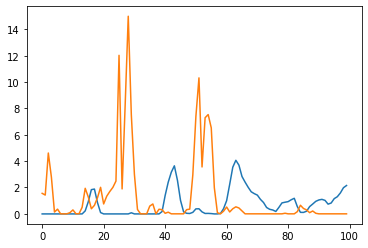

In [201]:
plt.plot(y_pred)
plt.plot(y_test)

In [ ]:
sc = joblib.load('./data/scaler.pkl')

## 함수형 API 적용

In [65]:
from keras import layers
from keras import Input
from keras.models import Model
from keras.utils import plot_model

In [17]:
reset_keras()

img_input = Input(shape=(None, 75, 75, 10), name='images')
convlstm2d = layers.ConvLSTM2D(filters=20, kernel_size=(3, 3),
                   input_shape=(None, 75, 75, 10),
                    data_format='channels_last',
                   padding='same')(img_input)
batch_norm = layers.BatchNormalization()(convlstm2d)

temp_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='temp')(batch_norm)
wind_dir_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='wind_dir')(batch_norm)
wind_speed_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='wind_speed')(batch_norm)
rainfall_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='rainfall')(batch_norm)
humid_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='humid')(batch_norm)
air_ground_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='air_ground')(batch_norm)
air_sea_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='air_sea')(batch_norm)
all_cloud_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='all_cloud')(batch_norm)
down_cloud_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='down_cloud')(batch_norm)
cloud_height_prediction = layers.Conv2D(filters=1, kernel_size=(3,3), data_format='channels_last', padding='same', name='cloud_height')(batch_norm)

model = Model(img_input, [temp_prediction, wind_dir_prediction, wind_speed_prediction, rainfall_prediction, humid_prediction, \
                          air_ground_prediction, air_sea_prediction, all_cloud_prediction, down_cloud_prediction, cloud_height_prediction])

model.compile(optimizer=rmsprop(lr=0.001), loss=['mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae', 'mae'])
model.summary()

0
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             (None, None, 75, 75, 0                                            
__________________________________________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)     (None, 75, 75, 20)   21680       images[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 75, 75, 20)   80          conv_lst_m2d_1[0][0]             
__________________________________________________________________________________________________
temp (Conv2D)                   (None, 75, 75, 1)    181         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
wind_dir

In [101]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback, data.shape[-3], data.shape[-2], data.shape[-1]))
        targets = np.zeros((len(rows), data.shape[-3], data.shape[-2], data.shape[-1]))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j])
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay]
        targets = np.expand_dims(np.rollaxis(targets, 1, 4), axis=3)
        return samples, [targets[:,:,:,:,0], targets[:,:,:,:,1], targets[:,:,:,:,2], targets[:,:,:,:,3], targets[:,:,:,:,4], \
                   targets[:,:,:,:,5], targets[:,:,:,:,6], targets[:,:,:,:,7], targets[:,:,:,:,8], targets[:,:,:,:,9]]

In [102]:
X_test, y_test = generator(test_data, 72, 0, 0, None, shuffle=True, batch_size=10)

In [110]:
X_test.shape, y_test[0].shape

((10, 72, 10, 75, 75), (10, 75, 75, 1))

In [111]:
y_test[0].shape

(10, 75, 75, 1)

In [119]:
np.rollaxis(X_test, 1, 4).shape, np.rollaxis(X_test, 2, 5).shape

((10, 10, 75, 72, 75), (10, 72, 75, 75, 10))

In [53]:
y_test[:,:,:,0].shape

(10, 75, 75)

In [108]:
y_test_ed = np.expand_dims(np.rollaxis(y_test, 1, 4), axis=3)
y_test_ed.shape

AttributeError: 'list' object has no attribute 'ndim'

In [62]:
y_test_ed[:,:,:,:,0].shape

(10, 75, 75, 1)

In [100]:
([y_test_ed[:,:,:,:,0], y_test_ed[:,:,:,:,1], y_test_ed[:,:,:,:,2], y_test_ed[:,:,:,:,3], y_test_ed[:,:,:,:,4], \
                   y_test_ed[:,:,:,:,5], y_test_ed[:,:,:,:,6], y_test_ed[:,:,:,:,7], y_test_ed[:,:,:,:,8], y_test_ed[:,:,:,:,9]])

(10, 10, 75, 75, 1)

In [63]:
model.fit(X_test, [y_test_ed[:,:,:,:,0], y_test_ed[:,:,:,:,1], y_test_ed[:,:,:,:,2], y_test_ed[:,:,:,:,3], y_test_ed[:,:,:,:,4], \
                   y_test_ed[:,:,:,:,5], y_test_ed[:,:,:,:,6], y_test_ed[:,:,:,:,7], y_test_ed[:,:,:,:,8], y_test_ed[:,:,:,:,9]])

Instructions for updating:
Use tf.cast instead.
Epoch 1/1


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv_lst_m2d_1/convolution}}]]
	 [[{{node loss/all_cloud_loss/Mean_3}}]]